In [6]:
#!pip install stockstats

In [27]:
import requests
import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import pi

from stockstats import StockDataFrame

from bokeh.plotting import figure, show, output_notebook, output_file

In [10]:
output_notebook()

Loading BokehJS ...

# Read in Daily Historical Crypto Price

In [89]:
def daily_price_historical(symbol, comparison_symbol, all_data=True, exchange=''):
    '''
    :params symbol: srt cryptoasset ticker e.x. BTC
    :params comparison_symbol: str ticker to compare to e.x. USD
    :params all_data: bool get all data
    :params limit: int rate limit
    :params aggregate: int increment to aggregate
    :params exchange: str token exchange ticker
    
    :returns pandas dataframe
    
    Accesses the CryptoCompare API and returns a pandas dataframe of all historical data
    '''
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}'\
            .format(symbol.upper(), comparison_symbol.upper())
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

In [90]:
symbol = "BTC"
comparison_symbol = "USD"
df = daily_price_historical(symbol, comparison_symbol)
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp
0,0.04951,0.04951,0.04951,0.04951,1279324800,20.00,0.9902,2010-07-16 20:00:00
1,0.08584,0.08585,0.05941,0.04951,1279411200,75.01,5.0900,2010-07-17 20:00:00
2,0.08080,0.09307,0.07723,0.08584,1279497600,574.00,49.6600,2010-07-18 20:00:00
3,0.07474,0.08181,0.07426,0.08080,1279584000,262.00,20.5900,2010-07-19 20:00:00
4,0.07921,0.07921,0.06634,0.07474,1279670400,575.00,42.2600,2010-07-20 20:00:00


In [91]:
start_date = pd.to_datetime('2017-01-01')
mask = (df['timestamp'] > start_date)
df = df.loc[mask]
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp
2361,1017.05,1031.68,990.20,995.44,1483315200,64951.63,6.603807e+07,2017-01-01 19:00:00
2362,1033.30,1035.47,1006.53,1017.05,1483401600,54788.01,5.608587e+07,2017-01-02 19:00:00
2363,1135.41,1148.54,1022.32,1033.30,1483488000,156272.17,1.705846e+08,2017-01-03 19:00:00
2364,989.35,1150.63,874.53,1135.41,1483574400,240007.84,2.448393e+08,2017-01-04 19:00:00
2365,886.16,1027.42,852.55,989.35,1483660800,194290.96,1.791607e+08,2017-01-05 19:00:00


# MACD (Moving Average Convergence Divergence)

In [92]:
df = StockDataFrame.retype(df)
df['macd'] = df.get('macd')
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp,close_12_ema,close_26_ema,macd,macds,macdh
2361,1017.05,1031.68,990.20,995.44,1483315200,64951.63,6.603807e+07,2017-01-01 19:00:00,1017.050000,1017.050000,0.000000,0.000000,0.000000
2362,1033.30,1035.47,1006.53,1017.05,1483401600,54788.01,5.608587e+07,2017-01-02 19:00:00,1025.852083,1025.487500,0.364583,0.202546,0.324074
2363,1135.41,1148.54,1022.32,1033.30,1483488000,156272.17,1.705846e+08,2017-01-03 19:00:00,1068.612564,1064.981587,3.630977,1.607641,4.046672
2364,989.35,1150.63,874.53,1135.41,1483574400,240007.84,2.448393e+08,2017-01-04 19:00:00,1043.592470,1043.838300,-0.245831,0.979771,-2.451203
2365,886.16,1027.42,852.55,989.35,1483660800,194290.96,1.791607e+08,2017-01-05 19:00:00,1000.818630,1007.272052,-6.453422,-1.231436,-10.443972


In [93]:
print(df.iloc[0,10])
print(df.iloc[0,11])

0.0
0.0


- close_12_ema is fast 12 days exponential moving average,
- close_26_ema is slow 26 days exponential moving average,
- macd is MACD line,
- macds is signal line,
- macdh is MACD histogram.


In [94]:
%matplotlib inline

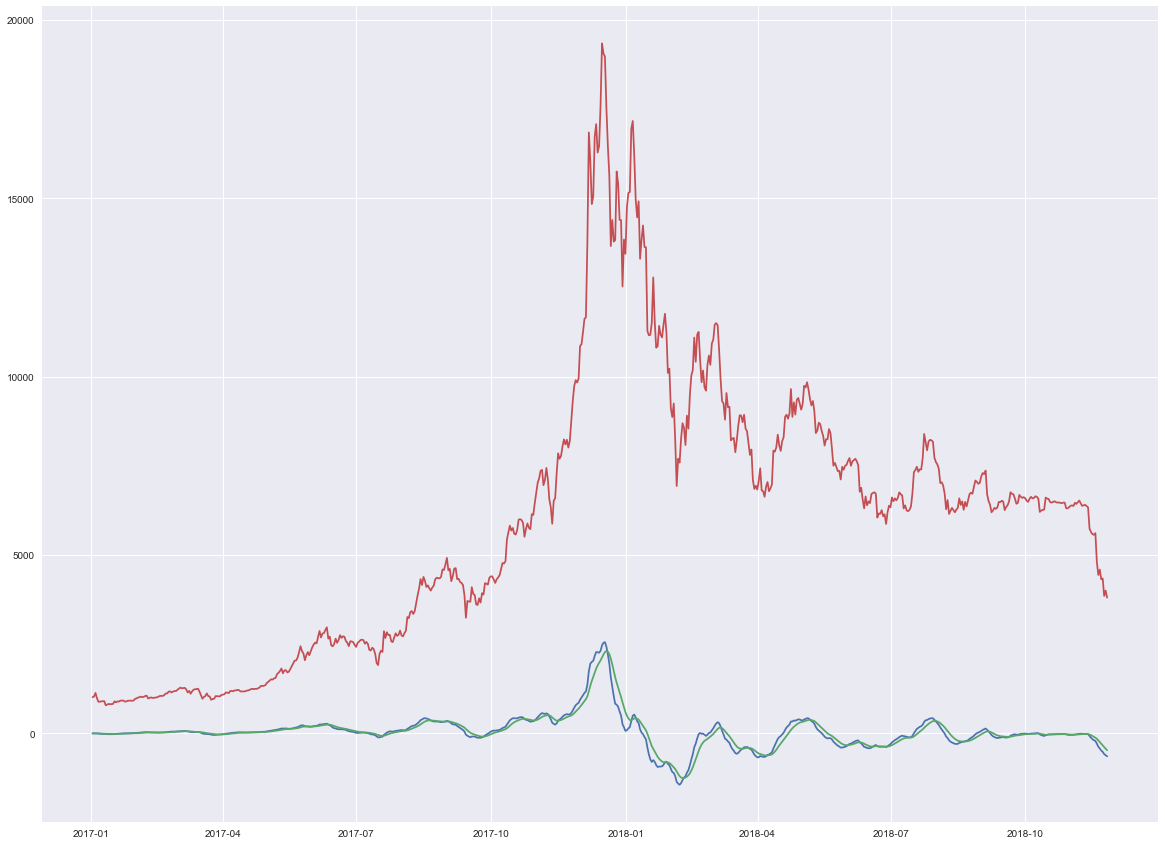

In [95]:
plt.figure(figsize = (20,15))
plt.plot('timestamp', 'macd', data = df)
plt.plot('timestamp', 'macds', data = df)
plt.plot('timestamp', 'close', data = df)

# MACD Backtest

In [96]:
def crossover(df, idx):
    if idx == 0:
        return("No Crossover")
    #print(df.head())
    prev_macd = df.iloc[idx-1, 10]
    prev_signal = df.iloc[idx-1, 11]
    current_macd = df.iloc[idx, 10]
    current_signal = df.iloc[idx, 11]
        
    if prev_signal < prev_macd and current_macd <= current_signal: # bullish crossover
        return("Bullish")
    elif prev_signal > prev_macd and current_macd >= current_signal: # bearish crossover
        return("Bearish")
    else: # no crossover
        return("No Crossover")

In [97]:
c = []
for x in range(len(df['timestamp'])):
    c.append(crossover(df,x))

In [98]:
c = pd.Series(c)
c.head()

0    No Crossover
1    No Crossover
2    No Crossover
3         Bullish
4    No Crossover
dtype: object

In [99]:
df = df.assign(crossover=c.values)

In [100]:
df.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp,close_12_ema,close_26_ema,macd,macds,macdh,crossover
2361,1017.05,1031.68,990.20,995.44,1483315200,64951.63,6.603807e+07,2017-01-01 19:00:00,1017.050000,1017.050000,0.000000,0.000000,0.000000,No Crossover
2362,1033.30,1035.47,1006.53,1017.05,1483401600,54788.01,5.608587e+07,2017-01-02 19:00:00,1025.852083,1025.487500,0.364583,0.202546,0.324074,No Crossover
2363,1135.41,1148.54,1022.32,1033.30,1483488000,156272.17,1.705846e+08,2017-01-03 19:00:00,1068.612564,1064.981587,3.630977,1.607641,4.046672,No Crossover
2364,989.35,1150.63,874.53,1135.41,1483574400,240007.84,2.448393e+08,2017-01-04 19:00:00,1043.592470,1043.838300,-0.245831,0.979771,-2.451203,Bullish
2365,886.16,1027.42,852.55,989.35,1483660800,194290.96,1.791607e+08,2017-01-05 19:00:00,1000.818630,1007.272052,-6.453422,-1.231436,-10.443972,No Crossover


In [103]:
mask = (df['crossover'] == 'Bullish') | (df['crossover'] == 'Bearish')
cross_df = df.loc[mask]
cross_df.head()
    

,close,high,low,open,time,volumefrom,volumeto,timestamp,close_12_ema,close_26_ema,macd,macds,macdh,crossover
2364,989.35,1150.63,874.53,1135.41,1483574400,240007.84,2.448393e+08,2017-01-04 19:00:00,1043.592470,1043.838300,-0.245831,0.979771,-2.451203,Bullish
2376,899.66,906.38,825.04,827.34,1484611200,82207.99,7.227273e+07,2017-01-16 19:00:00,862.312015,879.963767,-17.651752,-18.810502,2.317500,Bearish
2402,996.52,1007.82,992.45,1008.32,1486857600,14750.39,1.482502e+07,2017-02-11 19:00:00,998.344535,973.102908,25.241628,26.565220,-2.647184,Bullish
2408,1052.28,1063.21,1044.68,1049.41,1487376000,25362.02,2.685652e+07,2017-02-17 19:00:00,1018.502723,993.549768,24.952955,24.022477,1.860956,Bearish
2426,1146.97,1242.04,1136.88,1232.69,1488931200,97875.25,1.163430e+08,2017-03-07 19:00:00,1208.371345,1153.531375,54.839969,60.431711,-11.183484,Bullish


In [105]:
cross_df = cross_df[['close', 'high', 'low', 'open']]
cross_df.head()

,close,high,low,open
2364,989.35,1150.63,874.53,1135.41
2376,899.66,906.38,825.04,827.34
2402,996.52,1007.82,992.45,1008.32
2408,1052.28,1063.21,1044.68,1049.41
2426,1146.97,1242.04,1136.88,1232.69


In [110]:
returns_df = cross_df.pct_change()
returns_df

,close,high,low,open
2364,NaN,NaN,NaN,NaN
2376,-0.090655,-0.212275,-0.056590,-0.271329
2402,0.107663,0.111918,0.202911,0.218749
2408,0.055955,0.054960,0.052627,0.040751
2426,0.089986,0.168198,0.088257,0.174651
2449,-0.059165,-0.123861,-0.089455,-0.158012
2509,1.031813,1.140471,1.074132,1.194998
2511,0.100385,0.056490,0.072768,0.011031
2523,0.124486,0.131634,0.149392,0.153442
2560,0.056406,0.053161,-0.137994,-0.140844


In [111]:
trade_sum = returns_df['close'].sum()
print('Trade Sum: {}'.format(trade_sum))
if trade_sum > 0:
    print('Positive Return!')
elif trade_sum < 0:
    print('Negative Return!')
else:
    print('No Return!')

Trade Sum: 2.9239194691682835
Positive Return!
